# DoWhy: Different estimation methods for causal inference
This is quick introduction to DoWhy causal inference library. We will load in a sample dataset and use different methods for estimating causal effect from a (pre-specified) treatment variable to a (pre-specified) outcome variable.

In [1]:
%load_ext lab_black

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

Let us first load a dataset. For simplicity, we simulate a dataset with linear relationships between common causes and treatment, and common causes and outcome.

Beta is the true causal effect.

In [3]:
data = dowhy.datasets.linear_dataset(
    beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_samples=10000,
    treatment_is_binary=True,
)
df = data["df"]

In [4]:
data

{'df':        Z0        Z1        W0        W1        W2        W3        W4     v0  \
 0     1.0  0.205682 -0.556930  0.762743 -1.606946 -0.849534  2.350194   True   
 1     1.0  0.010341 -0.195173  1.285667 -1.979434  0.767274 -0.276447   True   
 2     1.0  0.200250 -1.318805  2.971130 -1.052902  0.422803  1.789567   True   
 3     0.0  0.418788  0.180307  0.207546 -0.272433 -1.930190 -0.132841  False   
 4     1.0  0.333549  0.762243  0.396756 -0.023027  0.976170  1.982673   True   
 ...   ...       ...       ...       ...       ...       ...       ...    ...   
 9995  1.0  0.491459  0.396911  0.308947  0.039739 -1.468032  1.252293   True   
 9996  0.0  0.945255  0.965977  1.801874 -1.971056  0.380577 -1.189544   True   
 9997  0.0  0.620020  1.721118  0.544636 -2.461803 -1.701381  1.641704   True   
 9998  1.0  0.024781  1.017494  0.098967 -0.815921  1.459497  0.513642   True   
 9999  1.0  0.529987  0.090256  1.039751 -0.306992 -2.127756  0.419934   True   
 
               y  
 

Note that we are using a pandas dataframe to load the data.

## Identifying the causal estimand
We now input a causal graph in the DOT graph format.

In [5]:
# With graph
model = CausalModel(
    data=df,
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"],
    instruments=data["instrument_names"],
    logging_level=logging.INFO,
)

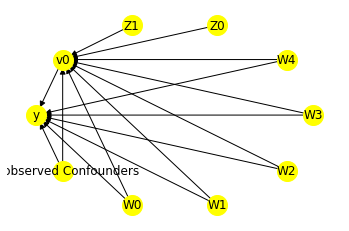

In [6]:
model.view_model()

We get a causal graph. Now identification and estimation is done.



In [7]:
identified_estimand = model.identify_effect()
print(identified_estimand)

WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n]  y


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W2,W4,W0,W3,W1))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W4,W0,W3,W1,U) = P(y|v0,W2,W4,W0,W3,W1)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable found!



### Method 1: Regression
Use linear regression.

In [8]:
causal_estimate_reg = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    test_significance=True,
)
print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W2,W4,W0,W3,W1))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W4,W0,W3,W1,U) = P(y|v0,W2,W4,W0,W3,W1)

## Realized estimand
b: y~v0+W2+W4+W0+W3+W1
Target units: ate

## Estimate
Mean value: 10.000556381226994
p-value: [0.]

Causal Estimate is 10.000556381226994


### Method 2: Stratification
We will be using propensity scores to stratify units in the data.

In [9]:
causal_estimate_strat = model.estimate_effect(
    identified_estimand, method_name="backdoor.propensity_score_stratification"
)
print(causal_estimate_strat)
print("Causal Estimate is " + str(causal_estimate_strat.value))

/tmp/Python/python-3.9.6/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W2,W4,W0,W3,W1))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W4,W0,W3,W1,U) = P(y|v0,W2,W4,W0,W3,W1)

## Realized estimand
b: y~v0+W2+W4+W0+W3+W1
Target units: ate

## Estimate
Mean value: 10.186646462087188

Causal Estimate is 10.186646462087188


/tmp/Python/python-3.9.6/lib/python3.9/site-packages/dowhy/causal_estimators/propensity_score_stratification_estimator.py:61: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_outcomes.columns = ["_".join(x) for x in weighted_outcomes.columns.ravel()]


###Method 3: Matching
We will be using propensity scores to match units in the data.

In [10]:
causal_estimate_match = model.estimate_effect(
    identified_estimand, method_name="backdoor.propensity_score_matching"
)
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

/tmp/Python/python-3.9.6/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W2,W4,W0,W3,W1))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W4,W0,W3,W1,U) = P(y|v0,W2,W4,W0,W3,W1)

## Realized estimand
b: y~v0+W2+W4+W0+W3+W1
Target units: ate

## Estimate
Mean value: 13.930058104841576

Causal Estimate is 13.930058104841576


### Method 4: Weighting
We will be using (inverse) propensity scores to assign weights to units in the data.

In [11]:
causal_estimate_ipw = model.estimate_effect(
    identified_estimand, method_name="backdoor.propensity_score_weighting"
)
print(causal_estimate_ipw)
print("Causal Estimate is " + str(causal_estimate_ipw.value))

/tmp/Python/python-3.9.6/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W2,W4,W0,W3,W1))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W4,W0,W3,W1,U) = P(y|v0,W2,W4,W0,W3,W1)

## Realized estimand
b: y~v0+W2+W4+W0+W3+W1
Target units: ate

## Estimate
Mean value: 15.700123213452287

Causal Estimate is 15.700123213452287
